3031


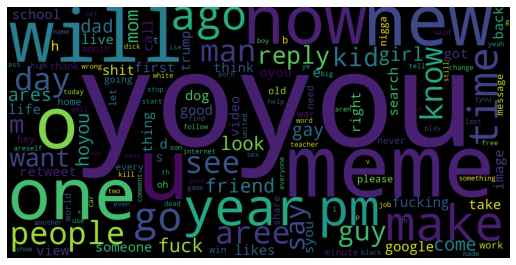

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys, json, random, string, re
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import nltk
#nltk.download('stopwords')

files = os.listdir("./data")

json_data = pd.DataFrame(columns=['src_lang', 'text', 'file_name', 'meme_id'])

for index, js in enumerate(files):
    with open(os.path.join('./data', js)) as json_file:
        json_text = json.load(json_file)
        src_lang = json_text['src_lang']
        text = json_text['text']
        file_name = json_text['file_name']
        meme_id = json_text['id']
        json_data.loc[index] = [src_lang, text, file_name, meme_id]

def clean_column(data):
    if data is not None:
        stopword_list = stopwords.words('english')
        data = data.lower()
        data = re.sub(r"\n", " ", data)
        data = re.sub(r"i'm", "i am", data)
        data = re.sub(r"\'re", " are", data)
        data = re.sub(r"\'d", " would", data)
        data = re.sub(r"\'ve", " have", data)
        data = re.sub(r"\'ll", " will", data)
        data = re.sub(r"can't", "cannot", data)
        data = re.sub(r"thats", "that is", data)
        data = re.sub(r"that's", "that is", data)
        data = re.sub(r"hes", "he is", data)
        data = re.sub(r"shes", "she is", data)
        data = re.sub(r"\'s", " is", data)
        data = re.sub(r"n't", " not", data)
        data = re.sub(r"ur", "you are", data)
        data = re.sub(r"u r", "you are", data)
        data = re.sub(r"[0-9]+", "", data)
        data = re.sub(r"[^\w\s]", "", data)
        return data

json_data['text'] = json_data['text'].apply(clean_column)
print(len(json_data))

stopwords = set(STOPWORDS)
wordcloud = WordCloud(
    collocations = False,
    width=1600, height=800,
    stopwords=stopwords,
    max_words=150,
    random_state=42
).generate(' '.join(json_data['text']))

print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [20]:
stemmer = PorterStemmer()
def stemming_tokenizer(input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [21]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokensize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [26]:
data = json_data['text']
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=5000)
tf_idf = tf_idf_vectorizer.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_arr = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_arr, columns=tf_idf_vectorizer.get_feature_names()).head()

/home/skuretski/anaconda3/envs/cs410/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,aa,aaa,aaaaa,aabbccddee,abc,ability,able,abortion,abs,absolutely,...,zuckerberg,zywy,įnvert,вае,воор,мaps,мe,ме,не,россия
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
